In [27]:
### Load libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
### Load data
df_path_abun = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/pathways_out/path_abun_contrib.tsv', sep='\t', dtype=str, header=0, usecols=['sample', 'function', 'taxon', 'taxon_abun', 'taxon_function_abun'])
df_path_abun_unstrat = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_unstratified/picrust2_out_pipeline_lasse/pathways_out/path_abun_unstrat.tsv', sep='\t', dtype=str, header=0)
df_tax = pd.read_csv('~/Thesis/data/tax_complete_qiime.txt', sep='\t', dtype=str, header=None, names=['taxon', 'taxonomy'])
df_meta = pd.read_csv('~/Thesis/data/metadata.txt', sep='\t', dtype=str, header=0, usecols=['Barcode ', 'ReactorID', 'SampleDate'])
df_nsti = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/KO_metagenome_out/weighted_nsti.tsv', sep='\t', dtype=str, header=0)
df_asv_nsti = pd.read_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/marker_predicted_and_nsti.tsv', sep='\t', dtype=str, header=0, usecols=['sequence', 'metadata_NSTI'])   

# Remove invisible spacings
df_path_abun['sample'] = df_path_abun['sample'].str.strip()

In [29]:
### Save files
df_path_abun.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_path_abun.tsv', sep='\t', index=False)
df_tax.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_tax.tsv', sep='\t', index=False)
df_meta.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_meta.tsv', sep='\t', index=False)
df_nsti.to_csv('~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/temp_diff/df_nsti.tsv', sep='\t', index=False)

In [30]:
# Filter for PR1 and PR4
df_meta.columns = df_meta.columns.str.strip()
barcodes = df_meta[df_meta['ReactorID'].isin(['PR1', 'PR4'])]['Barcode'].tolist()
df_path_abun = df_path_abun[df_path_abun['sample'].isin(barcodes)].copy()

PR1 = df_meta[df_meta['ReactorID'].isin(['PR1'])]['Barcode'].tolist()
PR4 = df_meta[df_meta['ReactorID'].isin(['PR4'])]['Barcode'].tolist()


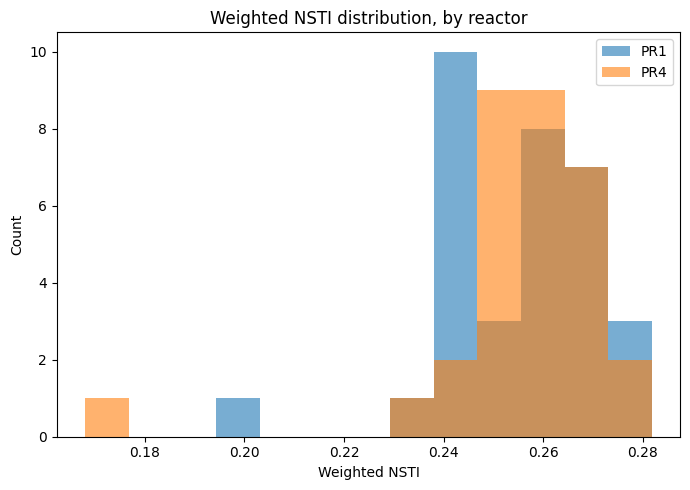

In [31]:
### Weighted NSTI distribution


# Numeric values
df_nsti['weighted_NSTI'] = pd.to_numeric(df_nsti['weighted_NSTI'], errors='coerce').copy()


# Boolean masks for PR1 and PR4
mask_pr1 = df_nsti['sample'].isin(PR1)
mask_pr4 = df_nsti['sample'].isin(PR4)

# Bins
all_vals = df_nsti.loc[mask_pr1 | mask_pr4, 'weighted_NSTI'].dropna().values
bins = np.histogram_bin_edges(all_vals, bins='auto') if len(all_vals) else 20

# Histogram of weighted NSTI values
plt.figure(figsize=(7, 5))
plt.hist(df_nsti.loc[mask_pr1, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR1', density=False)
plt.hist(df_nsti.loc[mask_pr4, 'weighted_NSTI'].dropna(), bins=bins, alpha=0.6, label='PR4', density=False)
plt.xlabel('Weighted NSTI')
plt.ylabel('Count')
plt.title('Weighted NSTI distribution, by reactor')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
### Genus-level pathway contributions for PR1 and PR4


# (1) Define pathways of interest
pathways = ['METH-ACETATE-PWY',
            'METHANOGENESIS-PWY']


# (2) Define df, select required columns
df = df_path_abun[['sample', 'function', 'taxon', 'taxon_function_abun']].copy()


# (3) Numeric values
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0.0)


# (4) Normalise taxonomy table whitespace
df_tax["taxon"] = df_tax["taxon"].str.strip()
df_tax["taxonomy"] = df_tax["taxonomy"].str.strip()


# (5) Merge taxonomy on stratified abundance table
df = df.merge(df_tax, on='taxon', how='left').copy()


# (6) Create dictionary for rank extraction
ranks = {
    "kingdom": "k__", "phylum": "p__", "class": "c__", "order": "o__",
    "family": "f__", "genus": "g__", "species": "s__"
}


# (7) Parse rank names out of taxonomy string
for col, prefix in ranks.items():
    df[col] = df["taxonomy"].str.extract(fr"{prefix}\s*([^;]+)", expand=False).str.strip()


# (8) Collapse ASV-level pathway abundances to genus-level for PR1
PR1_abun_genus = (
    df[df["sample"].isin(PR1)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)

# (9) Collapse ASV-level pathway abundances to genus-level for PR4
PR4_abun_genus = (
    df[df["sample"].isin(PR4)]
      .groupby(["function", "genus"], as_index=False)["taxon_function_abun"]
      .sum()
      .rename(columns={"taxon_function_abun": "total_contribution"})
)


/tmp/ipykernel_508177/3239591989.py:41: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  asv_taxon_genus_w.groupby("genus")
/tmp/ipykernel_508177/3239591989.py:52: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  asv_taxon_domain_w.groupby("domain")


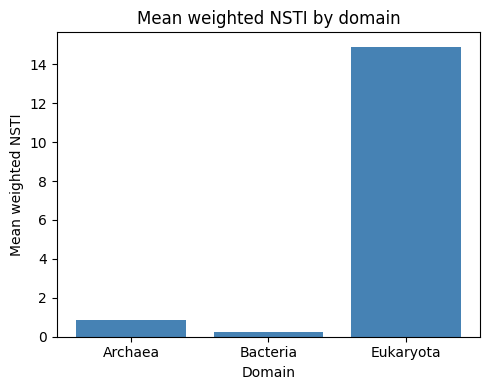

      domain  weighted_mean_NSTI
0    Archaea            0.859718
1   Bacteria            0.236381
2  Eukaryota           14.897951


In [57]:
### Taxonomy-weighted and unweighted NSTI by genus and domain


# (1) Harmonise and merge NSTIs onto asv_taxon (each ASV now has its NSTI and taxonomy)
df_asv_nsti = df_asv_nsti.rename(columns={"sequence":"taxon", "metadata_NSTI":"NSTI"}).copy()
asv_taxon = df_asv_nsti.merge(df_tax, on="taxon", how="left")

# (2) Extract domain-level and genus-level rows
asv_taxon["genus"] = (asv_taxon["taxonomy"].astype(str)
                      .str.extract(r"g__\s*([^;]+)", expand=False).str.strip())
asv_taxon["domain"] = (asv_taxon["taxonomy"].astype(str)
                       .str.extract(r"k__\s*([^;]+)", expand=False).str.strip())

# (3) Ensure numeric NSTI and keep rows with both NSTI and chosen rank present
asv_taxon["NSTI"] = pd.to_numeric(asv_taxon["NSTI"], errors="coerce")
asv_taxon_genus  = asv_taxon.dropna(subset=["NSTI","genus"])
asv_taxon_domain = asv_taxon.dropna(subset=["NSTI","domain"])

# (4) Collapse NSTI values to genus-level
genus_nsti = (
    asv_taxon_genus.groupby("genus")["NSTI"]
                   .agg(mean_NSTI="mean", median_NSTI="median", n_ASVs="size")
                   .reset_index()
)

# (5) Load per-sample ASV relative abundances to build weighting
abun = pd.read_csv("~/Thesis/data/picrust2_testruns/picrust2_stratified/picrust2_out_pipeline_stratified_lasse/KO_metagenome_out/seqtab_norm.tsv", sep="\t")
abun = abun.rename(columns={abun.columns[0]: "taxon"})
abun_long = abun.melt(id_vars=["taxon"], var_name="sample", value_name="rel_abun")
abun_long["rel_abun"] = pd.to_numeric(abun_long["rel_abun"], errors="coerce").fillna(0)

# (6) Collapse sample weights to a single weight per ASV
asv_weight = (abun_long.groupby("taxon")["rel_abun"].mean()
                        .reset_index().rename(columns={"rel_abun":"mean_rel_abun"}))

# (7) Genus-level weighted NSTI: abundance-weighted community perspective
asv_taxon_genus_w = (asv_taxon_genus.merge(asv_weight, on="taxon", how="left")
                                    .fillna({"mean_rel_abun":0}))

genus_nsti_weighted = (
    asv_taxon_genus_w.groupby("genus")
                     .apply(lambda d: np.average(d["NSTI"], weights=d["mean_rel_abun"])
                            if d["mean_rel_abun"].sum() > 0 else d["NSTI"].mean())
                     .reset_index(name="weighted_mean_NSTI")
)

# (8) Domain-level weighted NSTI (same approach)
asv_taxon_domain_w = (asv_taxon_domain.merge(asv_weight, on="taxon", how="left")
                                      .fillna({"mean_rel_abun":0}))

domain_nsti_weighted = (
    asv_taxon_domain_w.groupby("domain")
                      .apply(lambda d: np.average(d["NSTI"], weights=d["mean_rel_abun"])
                             if d["mean_rel_abun"].sum() > 0 else d["NSTI"].mean())
                      .reset_index(name="weighted_mean_NSTI")
)

# (9) Visualise domain-level weighted NSTI
plt.figure(figsize=(5,4))
plt.bar(domain_nsti_weighted["domain"], domain_nsti_weighted["weighted_mean_NSTI"], color="steelblue")
plt.ylabel("Mean weighted NSTI")
plt.xlabel("Domain")
plt.title("Mean weighted NSTI by domain")
plt.tight_layout()
plt.show()

# (10) Summary of exact mean weighted NSTI values
print(domain_nsti_weighted.head())


             taxon      NSTI  \
0      FLASV1.1417  0.349506   
1     FLASV10.1442  0.049060   
2    FLASV100.1441  0.070887   
3   FLASV1000.1425  0.025875   
4  FLASV10000.1306  0.003744   

                                            taxonomy               genus  \
0  k__Bacteria; p__Chloroflexi; c__Anaerolineae; ...       Ca_Amarolinea   
1  k__Bacteria; p__Actinobacteriota; c__Actinobac...  Ca_Phosphoribacter   
2  k__Bacteria; p__Actinobacteriota; c__Actinobac...         midas_g_100   
3  k__Bacteria; p__Firmicutes; c__Clostridia; o__...          Romboutsia   
4  k__Bacteria; p__Proteobacteria; c__Alphaproteo...      Porphyrobacter   

     domain  
0  Bacteria  
1  Bacteria  
2  Bacteria  
3  Bacteria  
4  Bacteria  


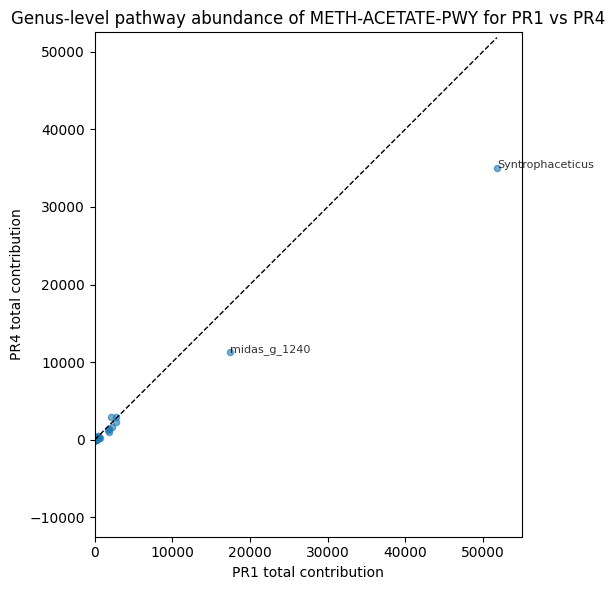

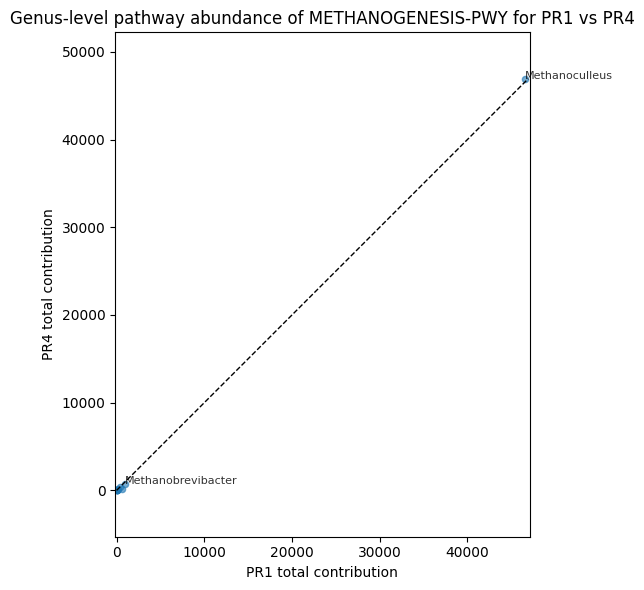

In [ ]:
### Genus-level comparison of pathway abundances between PR1 and PR4



## Acetoclastic methanogenesis ##

# (1) Genus level pathway abundance for acetoclastic methanogenesis
PR1_sub_ace = PR1_abun_genus[PR1_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()
PR4_sub_ace = PR4_abun_genus[PR4_abun_genus['function'] == 'METH-ACETATE-PWY'].copy()


# (2) Ensure the two columns exist and are numeric
merged_ace = PR1_sub_ace.merge(PR4_sub_ace, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged_ace[c] = pd.to_numeric(merged_ace[c], errors='coerce').fillna(0)


# (3) Scatterplot
plt.figure(figsize=(6,6))
x = merged_ace['total_contribution_PR1'].to_numpy()
y = merged_ace['total_contribution_PR4'].to_numpy()
top = merged_ace.nlargest(2, ['total_contribution_PR1', 'total_contribution_PR4']).copy()
for i, g in top.iterrows():
    plt.text(g['total_contribution_PR1'], g['total_contribution_PR4'], g['genus'], fontsize=8, alpha=0.8)
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level pathway abundance of METH-ACETATE-PWY for PR1 vs PR4')
plt.axis('equal'); plt.xlim(0, 55000); plt.ylim(0, 40000)
plt.tight_layout(); plt.show()




## Hydrogenotrophic methanogenesis ##

# (4) Genus level pathway abundance for hydrogenotrophic methanogenesis
PR1_sub_hyd = PR1_abun_genus[PR1_abun_genus['function'] == 'METHANOGENESIS-PWY'].copy()
PR4_sub_hyd = PR4_abun_genus[PR4_abun_genus['function'] == 'METHANOGENESIS-PWY'].copy()


# (5) Ensure the two columns exist and are numeric
merged_hyd = PR1_sub_hyd.merge(PR4_sub_hyd, on='genus', how='outer',
                       suffixes=('_PR1','_PR4')).fillna(0)
for c in ['total_contribution_PR1','total_contribution_PR4']:
    merged_hyd[c] = pd.to_numeric(merged_hyd[c], errors='coerce').fillna(0)


# (6) Scatterplot
plt.figure(figsize=(6,6))
x = merged_hyd['total_contribution_PR1'].to_numpy()
y = merged_hyd['total_contribution_PR4'].to_numpy()
top = merged_hyd.nlargest(2, ['total_contribution_PR1', 'total_contribution_PR4']).copy()
for i, g in top.iterrows():
    plt.text(g['total_contribution_PR1'], g['total_contribution_PR4'], g['genus'], fontsize=8, alpha=0.8)
plt.scatter(x, y, alpha=0.6, s=20)
m = np.nanmax(np.concatenate([x, y]))  # numeric max only
plt.plot([0, m], [0, m], 'k--', linewidth=1)  # 1:1 diagonal
plt.xlabel('PR1 total contribution')
plt.ylabel('PR4 total contribution')
plt.title('Genus-level pathway abundance of METHANOGENESIS-PWY for PR1 vs PR4')
plt.axis('equal'); plt.xlim(0, m); plt.ylim(0, m)
plt.tight_layout(); plt.show()


In [35]:
print(PR1_abun_genus.head())

     function           genus  total_contribution
0  1CMET2-PWY            28-4            8.000000
1  1CMET2-PWY           AAP99            2.000000
2  1CMET2-PWY  ADurb.Bin063-1            3.230769
3  1CMET2-PWY    ADurb.Bin118            2.153846
4  1CMET2-PWY        AUTHM297            0.330000


In [36]:
### Top contributing genera for METH-ACETATE-PWY and METHANOGENESIS-PWY

top15_PR1_ace = PR1_sub_ace.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR4_ace = PR4_sub_ace.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR1_hyd = PR1_sub_hyd.sort_values('total_contribution', ascending=False).head(15).copy()
top15_PR4_hyd = PR4_sub_hyd.sort_values('total_contribution', ascending=False).head(15).copy()


print('The top 15 contributing genera for acetoclastic methanogenesis in PR1 are ' + ', '.join(top15_PR1_ace['genus'].tolist()))
print('The top 15 contributing genera for acetoclastic methanogenesis in PR4 are ' + ', '.join(top15_PR4_ace['genus'].tolist()))
print('The top 15 contributing genera for hydrogenotrophic methanogenesis in PR1 are ' + ', '.join(top15_PR1_hyd['genus'].tolist()))
print('The top 15 contributing genera for hydrogenotrophic methanogenesis in PR4 are ' + ', '.join(top15_PR4_hyd['genus'].tolist()))


The top 15 contributing genera for acetoclastic methanogenesis in PR1 are Syntrophaceticus, midas_g_1240, midas_g_4921, midas_g_90696, Romboutsia, midas_g_92005, Moorella, Paeniclostridium, Terrisporobacter, midas_g_93804, Desulfitibacter, midas_g_93820, midas_g_917, midas_g_91516, midas_g_5068
The top 15 contributing genera for acetoclastic methanogenesis in PR4 are Syntrophaceticus, midas_g_1240, midas_g_92005, midas_g_90696, midas_g_4921, Romboutsia, Paeniclostridium, Terrisporobacter, Moorella, midas_g_93820, midas_g_3406, Desulfitibacter, midas_g_99090, midas_g_93804, midas_g_917
The top 15 contributing genera for hydrogenotrophic methanogenesis in PR1 are Methanoculleus, Methanobrevibacter, Methanobacterium, Methanothermobacter, Methanosphaera, Methanosarcina, Ca_Methanofastidiosum, Methanocorpusculum, Methanothrix, Methanospirillum, Methanomethylovorans
The top 15 contributing genera for hydrogenotrophic methanogenesis in PR4 are Methanoculleus, Methanobrevibacter, Methanothermo

In [ ]:
### Time-series pathway abundance

# (1) Merging data
df = df_path_abun.merge(df_meta, left_on='sample', right_on='Barcode', how='left').copy()


# (2) Numeric values
df['taxon_function_abun'] = pd.to_numeric(df['taxon_function_abun'], errors='coerce').fillna(0)


# (3) Convert date to datetime format
df['SampleDate'] = pd.to_datetime(df['SampleDate'], format='%m/%d/%Y').copy()


# (4) Collapse to sample (instead of ASV)
df_col = (
    df
    .groupby(['sample', 'function'], as_index=False)
    .agg(
        function_abun=('taxon_function_abun', 'sum'),
        SampleDate=('SampleDate', 'first'),
        ReactorID=('ReactorID', 'first')
    )
    .copy()
)


# Add date column to df_col
#df_col = df_col.merge(df[['sample', 'SampleDate']], on='sample', how='left').copy()

/tmp/ipykernel_508177/2187951739.py:97: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


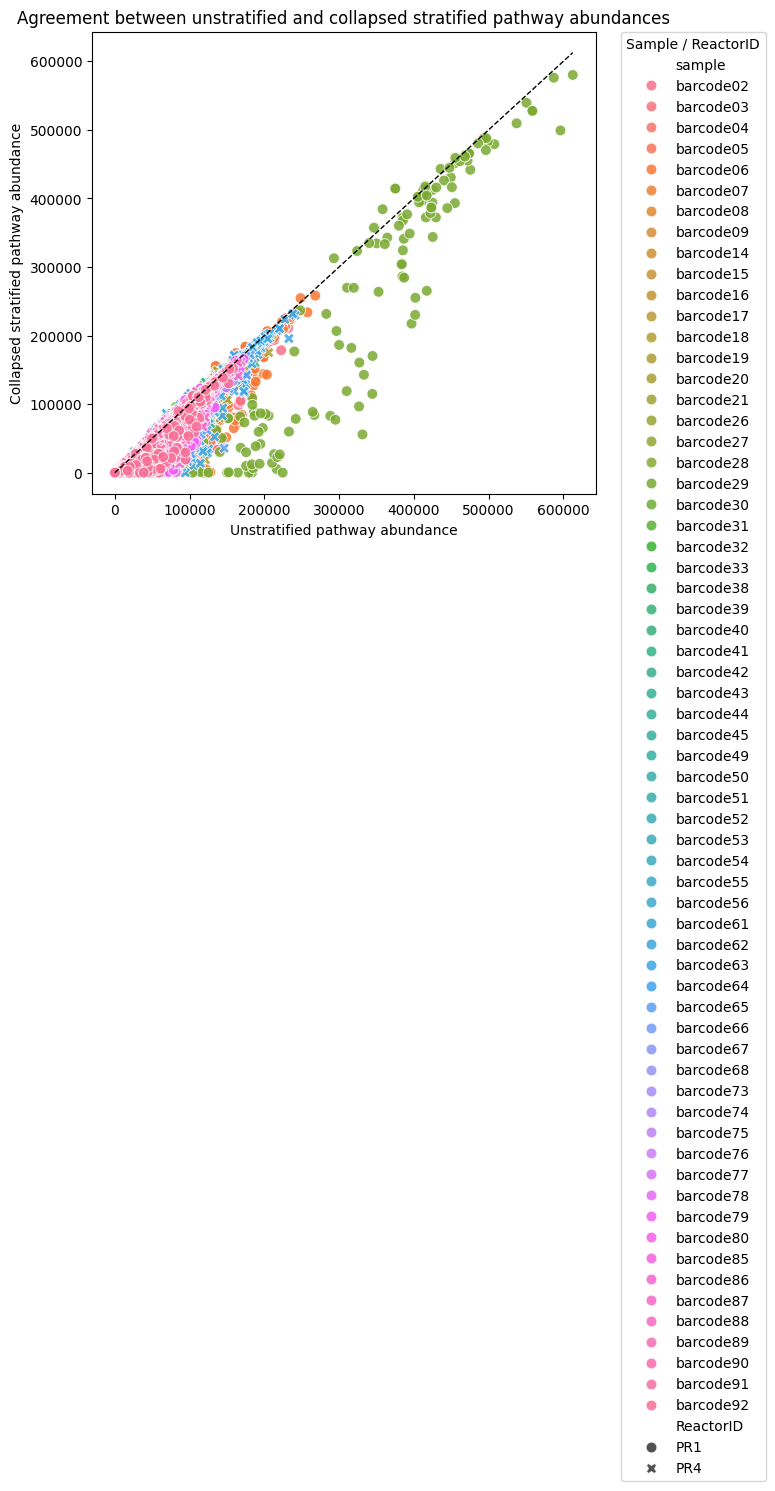

In [ ]:
### Investigate discrepancy between collapsed stratified and unstratified results


# (1) Collapse stratified table to sample × pathway totals
df_path_abun = df_path_abun.copy()
df_path_abun["taxon_function_abun"] = pd.to_numeric(df_path_abun["taxon_function_abun"], errors="coerce").fillna(0)

pathway_abundance = (
    df_path_abun.groupby(["sample", "function"], as_index=False)["taxon_function_abun"]
                .sum()
                .rename(columns={"taxon_function_abun": "pathway_abundance_collapsed"})
)


# (2) Unstratified table: wide → long (sample × pathway), ensure numeric
u = df_path_abun_unstrat.copy()

# Detect pathway ID column
if "function" in u.columns:
    id_col = "function"
elif "pathway" in u.columns:
    id_col = "pathway"
else:
    id_col = u.columns[0]  # fallback: first column is the pathway ID

u = u.rename(columns={id_col: "function"})

un_long = (
    u.melt(id_vars=["function"], var_name="sample", value_name="pathway_abundance_unstrat")
)
un_long["sample"] = un_long["sample"].astype(str).str.strip()
un_long["function"] = un_long["function"].astype(str).str.strip()
un_long["pathway_abundance_unstrat"] = pd.to_numeric(
    un_long["pathway_abundance_unstrat"], errors="coerce"
).fillna(0)


# (3) Align keys and merge collapsed vs unstratified
pathway_abundance["sample"] = pathway_abundance["sample"].astype(str).str.strip()
pathway_abundance["function"] = pathway_abundance["function"].astype(str).str.strip()

merged_comp = pathway_abundance.merge(un_long, on=["sample", "function"], how="inner")


# (4) Compute differences (protect against division by ~0)
eps = 1e-12
merged_comp["difference"] = (
    merged_comp["pathway_abundance_unstrat"] - merged_comp["pathway_abundance_collapsed"]
)
merged_comp["relative_diff_%"] = (
    merged_comp["difference"] / (merged_comp["pathway_abundance_collapsed"] + eps) * 100
)
# Optional: log2 fold change (numerically stable)
# merged_comp["log2_fold"] = np.log2(
#     (merged_comp["pathway_abundance_unstrat"] + eps) / (merged_comp["pathway_abundance_collapsed"] + eps)
# )


# (5) Attach reactor metadata (style variable for plotting)
meta = df_meta.copy()
meta.columns = meta.columns.str.strip()

# (6) Normalize barcode column to 'sample'
if "Barcode" in meta.columns:
    barcode_col = "Barcode"
elif "Barcode " in meta.columns:
    barcode_col = "Barcode "
else:
    raise ValueError("df_meta must contain 'Barcode' (or 'Barcode ').")

meta = meta.rename(columns={barcode_col: "sample"})
meta["sample"] = meta["sample"].astype(str).str.strip()
meta["ReactorID"] = meta["ReactorID"].astype(str).str.strip()

merged_comp = merged_comp.merge(meta[["sample", "ReactorID"]], on="sample", how="left")


# (7) Scatterplot: collapsed vs unstratified with 1:1 line
plt.figure(figsize=(6.5, 6))
sns.scatterplot(
    data=merged_comp,
    x="pathway_abundance_unstrat",
    y="pathway_abundance_collapsed",
    hue="sample",
    style="ReactorID",
    s=60,
    alpha=0.85
)

m = merged_comp[["pathway_abundance_unstrat", "pathway_abundance_collapsed"]].to_numpy().max()
plt.plot([0, m], [0, m], "k--", lw=1)

plt.xlabel("Unstratified pathway abundance")
plt.ylabel("Collapsed stratified pathway abundance")
plt.title("Agreement between unstratified and collapsed stratified pathway abundances")
plt.legend(title="Sample / ReactorID", bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

Compared pairs: 64
Pearson r: 0.998 | MAE: 956 | MAPE: 41.47%
Unmatched functions (strat-only): 0
Unmatched functions (unstrat-only): 33
Unmatched samples (strat-only): 0
Unmatched samples (unstrat-only): 0


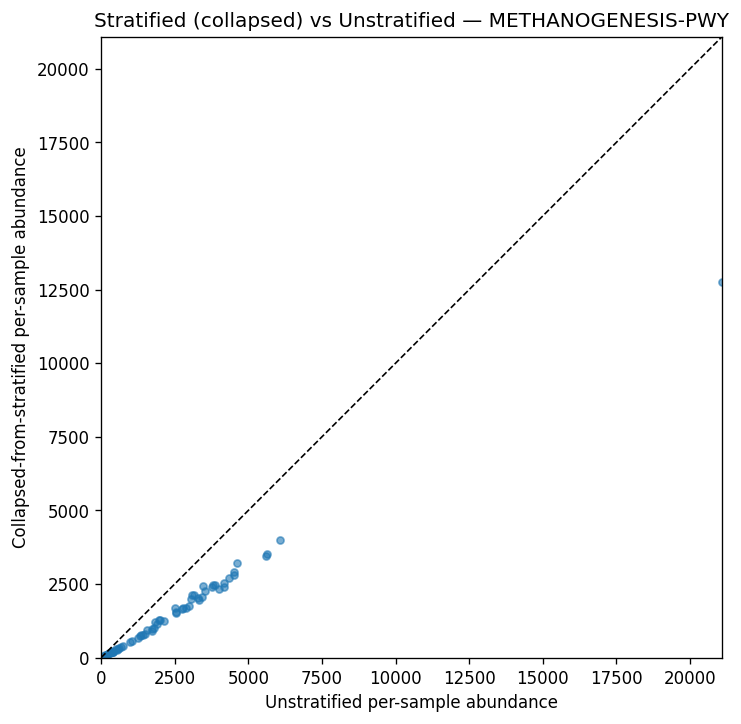

In [ ]:
### Scatterplot: agreement between collapsed stratified and unstratified pathway abundances


# (0) Define pathway of interest
PATH = "METHANOGENESIS-PWY"


# (1) Stratified table → collapse to per-sample × per-function totals
df_strat = df_path_abun[['sample', 'function', 'taxon_function_abun']].copy()
df_strat['taxon_function_abun'] = pd.to_numeric(df_strat['taxon_function_abun'], errors='coerce').fillna(0)
df_strat = (df_strat
            .groupby(['sample','function'], as_index=False)['taxon_function_abun']
            .sum()
            .rename(columns={'taxon_function_abun':'from_strat'}))

# Normalise join keys (trim + uppercase) to ensure alignment with unstratified table headers
for c in ['sample','function']:
    df_strat[c] = df_strat[c].astype(str).str.strip().str.upper()

# Capture the set of samples actually present after collapsing to filter the unstratified table
samples = pd.Index(df_strat['sample'].unique())


# (2) Unstratified table (wide) → long (sample × function value)
df_un = df_path_abun_unstrat.copy()
df_un.columns = [c.strip().upper() for c in df_un.columns]
id_col = 'FUNCTION' if 'FUNCTION' in df_un.columns else ('PATHWAY' if 'PATHWAY' in df_un.columns else None)
if id_col is None:
    raise ValueError("Could not find function/pathway id column in unstratified table.")

keep = [id_col] + [c for c in df_un.columns if c in samples]
df_un = df_un[keep].copy()

# Melt to long format, normalise keys, coerce values to numeric
un_long = (df_un
           .melt(id_vars=[id_col], var_name='sample', value_name='from_unstrat')
           .rename(columns={id_col: 'function'}))
for c in ['sample','function']:
    un_long[c] = un_long[c].astype(str).str.strip().str.upper()
un_long['from_unstrat'] = pd.to_numeric(
    un_long['from_unstrat'].astype(str).str.replace(',', '', regex=False),
    errors='coerce'
).fillna(0)


# (3) Merge paired measurements and compute diagnostics
cmp = df_strat.merge(un_long, on=['sample','function'], how='outer')
cmp['from_strat']   = pd.to_numeric(cmp['from_strat'], errors='coerce').fillna(0)
cmp['from_unstrat'] = pd.to_numeric(cmp['from_unstrat'], errors='coerce').fillna(0)

# Differences: absolute (for magnitude) and relative (scale-aware; NaN when unstrat is zero)
cmp['abs_diff'] = (cmp['from_strat'] - cmp['from_unstrat']).abs()
cmp['rel_diff'] = np.where(cmp['from_unstrat'] > 0,
                           cmp['abs_diff'] / cmp['from_unstrat'].abs(),
                           np.nan)

# Optional: restrict to a single pathway; then keep rows measured in at least one source
plot_df = cmp if PATH is None else cmp[cmp['function'] == PATH].copy()
mask = (plot_df['from_strat'] > 0) | (plot_df['from_unstrat'] > 0)
plot_df = plot_df[mask]

# Summary agreement metrics for the plotted pairs
n_pairs = len(plot_df)
pearson = (np.corrcoef(plot_df['from_unstrat'], plot_df['from_strat'])[0,1]
           if n_pairs >= 2 else np.nan)
mae  = float(np.nanmean(plot_df['abs_diff']))
mape = float(np.nanmean(plot_df['rel_diff']) * 100)

print(f"Compared pairs: {n_pairs}")
print(f"Pearson r: {pearson:.3f} | MAE: {mae:.3g} | MAPE: {mape:.2f}%")

# Quick sanity checks to spot join/key issues across sources.
print("Unmatched functions (strat-only):", len(set(df_strat['function']) - set(un_long['function'])))
print("Unmatched functions (unstrat-only):", len(set(un_long['function']) - set(df_strat['function'])))
print("Unmatched samples (strat-only):", len(set(df_strat['sample']) - set(un_long['sample'])))
print("Unmatched samples (unstrat-only):", len(set(un_long['sample']) - set(df_strat['sample'])))


# (4) Scatter plot: collapsed stratified vs unstratified per-sample abundance
x = plot_df['from_unstrat'].to_numpy()
y = plot_df['from_strat'].to_numpy()

plt.close('all')
fig, ax = plt.subplots(figsize=(6,6), dpi=120, constrained_layout=True)
ax.scatter(x, y, alpha=0.6, s=18)

m = float(np.nanmax(np.concatenate([np.nan_to_num(x), np.nan_to_num(y), [1]])))
ax.plot([0, m], [0, m], 'k--', linewidth=1)
title = 'All functions' if PATH is None else PATH
ax.set_title(f'Stratified (collapsed) vs Unstratified — {title}')
ax.set_xlabel('Unstratified per-sample abundance')
ax.set_ylabel('Collapsed-from-stratified per-sample abundance')
ax.set_xlim(0, m); ax.set_ylim(0, m); ax.set_aspect('equal', adjustable='box')


In [40]:
print(df_meta.head())

     Barcode ReactorID SampleDate
0  barcode01       NaN   2/7/2024
1  barcode13       NaN   2/7/2024
2  barcode25       NaN   5/6/2024
3  barcode37       NaN   5/6/2024
4  barcode49       PR1  2/20/2023


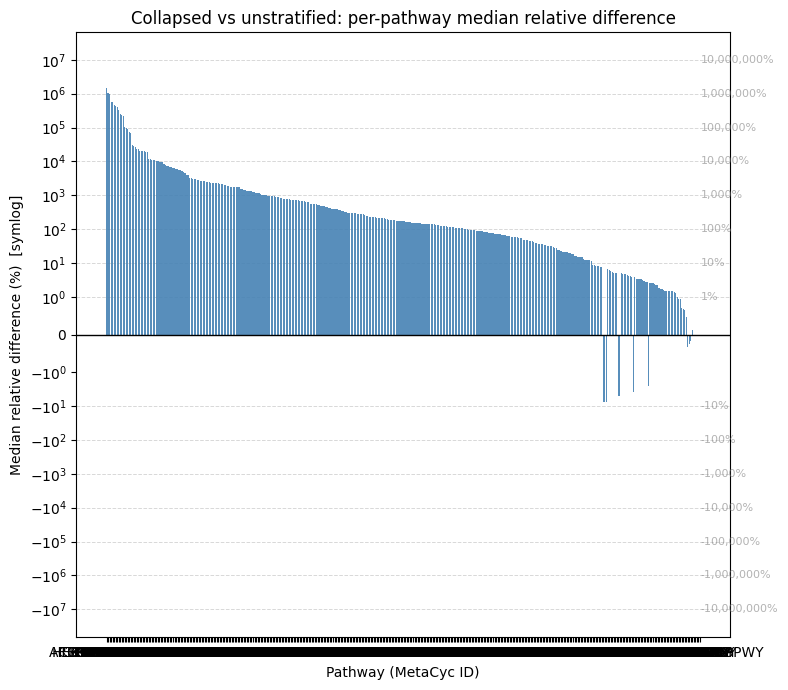

In [63]:
### Per-pathway median relative difference barplot


# (1) Clean input: ensure numeric, drop inf/NaN
merged_comp = merged_comp.copy()
merged_comp["relative_diff_%"] = pd.to_numeric(merged_comp["relative_diff_%"], errors="coerce")
merged_comp = merged_comp.replace([np.inf, -np.inf], np.nan).dropna(subset=["relative_diff_%"])

# (2) Aggregate per pathway: median relative difference + sample count
agg = (
    merged_comp.groupby("function", as_index=False)["relative_diff_%"]
               .agg(median_rel_diff_pct="median", n="count")
)

# (3) Order pathways by absolute median difference (largest first)
agg = agg.reindex(agg["median_rel_diff_pct"].abs().sort_values(ascending=False).index)

# (4) Barplot (symlog y-scale to preserve sign, compress extremes)
plt.figure(figsize=(8, 7))
bars = plt.bar(agg["function"], agg["median_rel_diff_pct"], color="steelblue", alpha=0.9)
plt.axhline(0, color="k", lw=1)
plt.yscale("symlog", linthresh=1)   # linear near 0, log elsewhere

# (4.5) Add horizontal translucent percentage guide lines (log-spaced)
ymax = np.nanmax(np.abs(agg["median_rel_diff_pct"]))
guide_levels = np.logspace(0, np.ceil(np.log10(ymax)), num=int(np.ceil(np.log10(ymax))) + 1, base=10)

for val in guide_levels:
    # Positive lines (all)
    plt.axhline(val, color="grey", linestyle="--", lw=0.7, alpha=0.3, zorder=0)
    plt.text(len(agg) - 0.3, val, f"{val:,.0f}%", color="grey", alpha=0.6,
             va="center", ha="left", fontsize=8)

    # Negative lines (only below -10)
    if val >= 10:
        plt.axhline(-val, color="grey", linestyle="--", lw=0.7, alpha=0.3, zorder=0)
        plt.text(len(agg) - 0.3, -val, f"-{val:,.0f}%", color="grey", alpha=0.6,
                 va="center", ha="left", fontsize=8)

# (5) Labels, title, and layout
plt.ylabel("Median relative difference (%)  [symlog]")
plt.xlabel("Pathway (MetaCyc ID)")
plt.title("Collapsed vs unstratified: per-pathway median relative difference")
plt.tight_layout()
plt.show()


In [42]:
### Top 25 pathways with median relative difference (%)

top25 = agg.reindex(agg["median_rel_diff_pct"].abs().sort_values(ascending=False).index).head(25)

print(top25)

                function  median_rel_diff_pct   n
99               P23-PWY         1.514505e+06  47
259             PWY-6590         1.019048e+06  21
361             PWY0-781         9.820929e+05  57
106             P441-PWY         5.753431e+05  58
19          CENTFERM-PWY         5.676774e+05  39
231             PWY-6263         4.598583e+05  18
335             PWY-7456         4.368865e+05  14
188             PWY-5838         4.142966e+05  58
120             PRPP-PWY         3.262947e+05  64
196             PWY-5861         2.541776e+05  59
281             PWY-6901         2.401365e+05  64
362             PWY0-845         2.254751e+05  63
6      ARG+POLYAMINE-SYN         1.052914e+05  64
23          COLANSYN-PWY         9.850591e+04  64
56        GLYCOLYSIS-E-D         9.243137e+04  64
323             PWY-7332         7.413194e+04  64
104               P4-PWY         6.937023e+04  64
279             PWY-6895         3.021153e+04  64
208             PWY-5971         2.768948e+04  39


/tmp/ipykernel_508177/1133728957.py:84: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()
/tmp/ipykernel_508177/1133728957.py:84: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.autofmt_xdate()


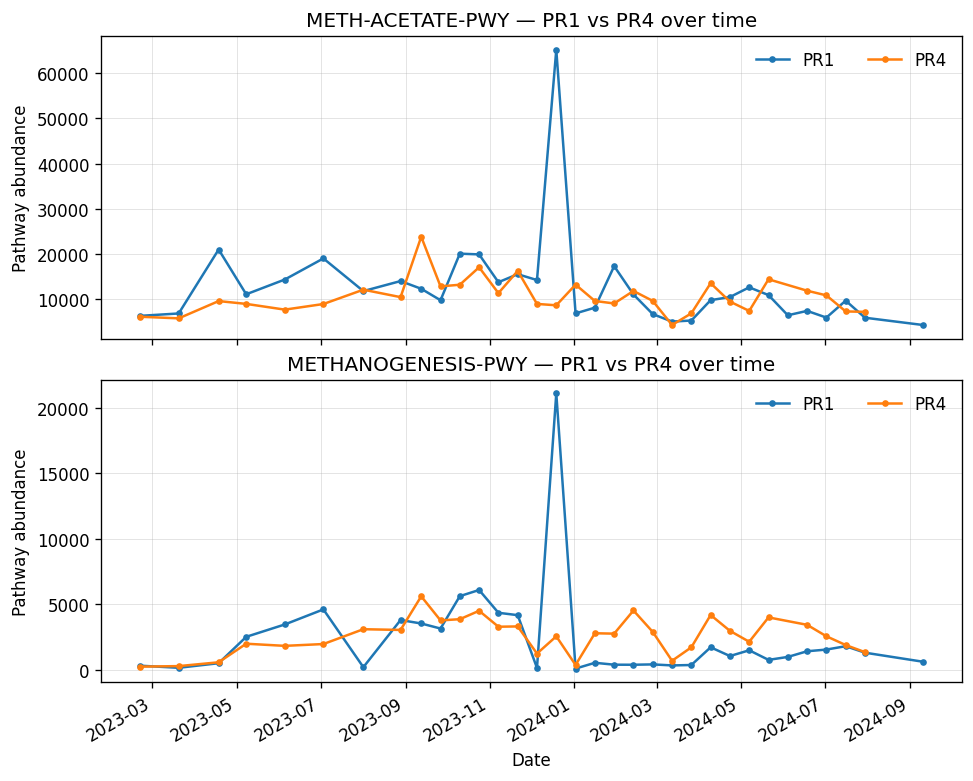

ReactorID                              PR1           PR4         DIFF
SampleDate function                                                  
2024-06-18 METH-ACETATE-PWY    7344.158871  11814.547036  4470.388165
           METHANOGENESIS-PWY  1417.523488   3433.076647  2015.553159
2024-07-02 METH-ACETATE-PWY    5859.498365  10779.526598  4920.028232
           METHANOGENESIS-PWY  1545.427581   2560.030856  1014.603274
2024-07-16 METH-ACETATE-PWY    9612.619196   7224.285062 -2388.334134
           METHANOGENESIS-PWY  1802.481592   1891.556546    89.074955
2024-07-30 METH-ACETATE-PWY    5827.291028   7130.691329  1303.400300
           METHANOGENESIS-PWY  1308.400987   1349.102410    40.701423
2024-09-10 METH-ACETATE-PWY    4219.608293      0.000000 -4219.608293
           METHANOGENESIS-PWY   620.100008      0.000000  -620.100008


In [43]:
### Pathway abundance over time in PR1 and PR4


# (0) Config: pathways to plot (case-insensitive after normalization below)
PATHS = {"METHANOGENESIS-PWY", "METH-ACETATE-PWY"}


# (1) Clean metadata: standardize names, restrict to PR1/PR4, parse dates
dfm = df_meta.copy()
dfm.columns = dfm.columns.str.strip()

# Normalize sample/barcode column name to 'sample'
barcode_col = "Barcode" if "Barcode" in dfm.columns else ("Barcode " if "Barcode " in dfm.columns else None)
if barcode_col is None:
    raise ValueError("df_meta must contain a 'Barcode' (or 'Barcode ') column.")
dfm = dfm.rename(columns={barcode_col: "sample"})

# String-clean and parse
dfm["sample"] = dfm["sample"].astype(str).str.strip().str.upper()
dfm["ReactorID"] = dfm["ReactorID"].astype(str).str.strip().str.upper()
dfm["SampleDate"] = pd.to_datetime(dfm["SampleDate"], errors="coerce")

# Keep only PR1/PR4 rows with valid dates
dfm = dfm[dfm["ReactorID"].isin(["PR1", "PR4"])].copy()
dfm = dfm.dropna(subset=["SampleDate"])


# (2) Unstratified pathway table: normalize headers, select usable samples, melt to long
u = df_path_abun_unstrat.copy()
u.columns = [c.strip().upper() for c in u.columns]

# Detect pathway ID column (after uppercasing)
id_col = "FUNCTION" if "FUNCTION" in u.columns else ("PATHWAY" if "PATHWAY" in u.columns else None)
if id_col is None:
    raise ValueError("Unstratified table needs an ID column named 'function' or 'pathway' (any case).")

# Keep only pathway column + samples present in metadata subset
keep_samples = set(dfm["sample"])
keep_cols = [id_col] + [c for c in u.columns if c in keep_samples]
u = u[keep_cols].copy()

# Long format and clean types
long_u = (
    u.melt(id_vars=[id_col], var_name="sample", value_name="abun")
     .rename(columns={id_col: "function"})
)
long_u["sample"] = long_u["sample"].astype(str).str.strip().str.upper()
long_u["function"] = long_u["function"].astype(str).str.strip().str.upper()
long_u["abun"] = pd.to_numeric(long_u["abun"], errors="coerce").fillna(0)


# (3) Attach metadata and filter to target pathways and reactors
sub = (
    long_u.merge(dfm[["sample", "SampleDate", "ReactorID"]], on="sample", how="inner")
          .query("function in @PATHS and ReactorID in ['PR1','PR4']")
)


# (4) Aggregate per date × reactor × pathway (sum across replicates if any)
ts = (
    sub.groupby(["SampleDate", "ReactorID", "function"], as_index=False)["abun"]
       .sum()
       .sort_values(["function", "SampleDate", "ReactorID"])
)


# (5) Plot: one panel per pathway; lines for PR1 vs PR4
paths_sorted = sorted(PATHS)
fig, axes = plt.subplots(
    nrows=len(paths_sorted), ncols=1, figsize=(8, 3.2 * len(paths_sorted)), dpi=120, constrained_layout=True
)
if len(paths_sorted) == 1:
    axes = [axes]

for ax, pw in zip(axes, paths_sorted):
    g = ts[ts["function"] == pw]
    for rid, gg in g.groupby("ReactorID", sort=False):
        ax.plot(gg["SampleDate"], gg["abun"], marker="o", linewidth=1.5, markersize=3, label=rid)
    ax.set_title(f"{pw} — PR1 vs PR4 over time")
    ax.set_xlabel("Date")
    ax.set_ylabel("Pathway abundance")
    ax.grid(True, linewidth=0.4, alpha=0.5)
    ax.legend(frameon=False, ncol=2)
    fig.autofmt_xdate()

plt.show()


# (6) Optional: table of PR1/PR4 values and their difference per date × pathway
wide = (
    ts.pivot_table(index=["SampleDate", "function"], columns="ReactorID", values="abun", fill_value=0)
      .assign(DIFF=lambda d: d.get("PR4", 0) - d.get("PR1", 0))
      .sort_index()
)
print(wide.tail(10))


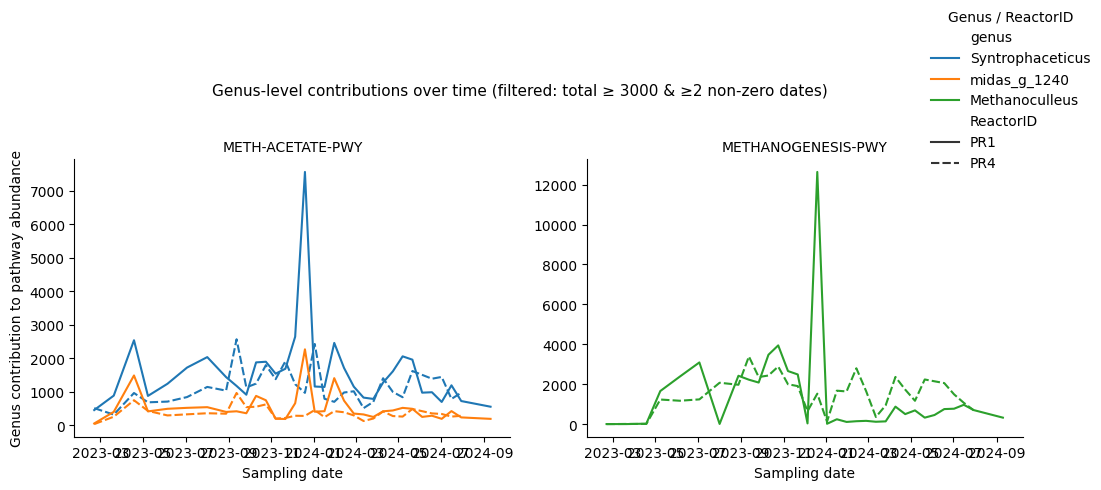

In [44]:
# (1) Select required columns from stratified pathway contributions
df = df_path_abun[["sample", "function", "taxon", "taxon_function_abun"]].copy()

# (2) Attach taxonomy to ASVs
df = df.merge(df_tax[["taxon", "taxonomy"]], on="taxon", how="left")

# (3) Attach reactor + date metadata; keep only desired barcodes
meta = (df_meta.loc[df_meta["Barcode"].isin(barcodes), ["Barcode", "ReactorID", "SampleDate"]]
              .rename(columns={"Barcode": "sample"}))
df = df.merge(meta, on="sample", how="inner")

# (4) Parse dates and extract genus from taxonomy
df["SampleDate"] = pd.to_datetime(df["SampleDate"], errors="coerce")
df["genus"] = (df["taxonomy"].astype(str)
               .str.extract(r"g__\s*([^;]+)", expand=False)
               .str.strip()
               .fillna("Unclassified"))

# (5) Ensure numeric abundances
df["taxon_function_abun"] = pd.to_numeric(df["taxon_function_abun"], errors="coerce").fillna(0)

# (6) Collapse ASV → genus per (pathway × reactor × date)
df_col = (df.groupby(["function", "genus", "ReactorID", "SampleDate"], as_index=False)["taxon_function_abun"]
            .sum()
            .rename(columns={"taxon_function_abun": "genus_contribution"}))

# (7) Filter to selected pathways (e.g., two methanogenesis routes)
df_col = df_col[df_col["function"].isin(pathways)].copy()

# (8) Thresholding: keep genera with sufficient total signal and temporal support
min_total = 3000        # minimal summed contribution across all dates (per reactor × pathway × genus)
min_nonzero_dates = 2   # require ≥ this many dates with non-zero contribution
tot = (df_col.groupby(["ReactorID", "function", "genus"])["genus_contribution"].transform("sum"))
nz  = (df_col.groupby(["ReactorID", "function", "genus"])["genus_contribution"].transform(lambda s: (s > 0).sum()))
df_plot = df_col[(tot >= min_total) & (nz >= min_nonzero_dates)].copy()

# (9) Time-series plot: per-pathway panels; color = genus, line style = reactor
g = sns.relplot(
    data=df_plot,
    x="SampleDate",
    y="genus_contribution",
    hue="genus",
    style="ReactorID",
    col="function",
    kind="line",
    errorbar=None,
    height=4, aspect=1.1,
    facet_kws={"sharex": True, "sharey": False}
)

g.set_axis_labels("Sampling date", "Genus contribution to pathway abundance")
g.set_titles("{col_name}")
g.fig.suptitle(
    "Genus-level contributions over time (filtered: total ≥ 3000 & ≥2 non-zero dates)",
    fontsize=11, y=1.03
)
# Move legend outside and set a single concise title
leg = g._legend
if leg is not None:
    leg.set_bbox_to_anchor((1.05, 1))
    leg.set_title("Genus / ReactorID")

plt.tight_layout()
plt.show()


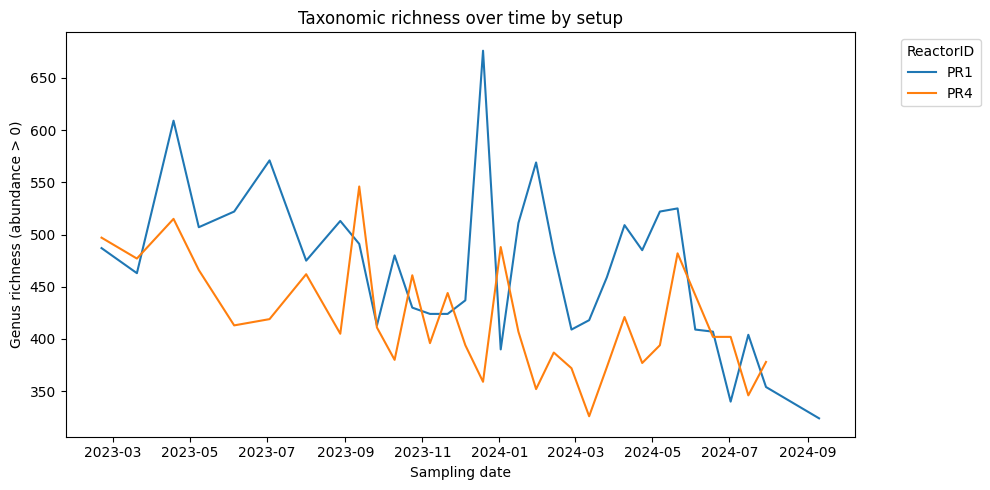

In [45]:
### Assessment of taxonomic richness as time-series (genus-level)



# (1) Load ASV abundance, keep only ASV ID and selected barcodes
path_seqtab = (
    "~/Thesis/data/picrust2_testruns/picrust2_stratified/"
    "picrust2_out_pipeline_stratified_lasse/EC_metagenome_out/seqtab_norm.tsv"
)

# Read header to detect the ASV ID column name (e.g. 'feature_id')
hdr = pd.read_csv(path_seqtab, sep="\t", nrows=0)
id_col = hdr.columns[0]

usecols = [id_col] + barcodes
df_seq = pd.read_csv(path_seqtab, sep="\t", usecols=usecols, dtype=str)

# Standardise ASV ID column name to 'taxon'
df_seq = df_seq.rename(columns={id_col: "taxon"})

# Ensure numeric abundances; non-parsable values → 0
df_seq[barcodes] = df_seq[barcodes].apply(pd.to_numeric, errors="coerce").fillna(0)


# (2) Map ASV to genus based on taxonomy table
tax = df_tax[["taxon", "taxonomy"]].copy()
tax["genus"] = (
    tax["taxonomy"].astype(str)
       .str.extract(r"g__\s*([^;]+)", expand=False)
       .str.strip()
       .replace({"": np.nan})
       .fillna("Unclassified")
)

# Join genus annotation onto ASV abundance table
dfm = df_seq.merge(tax[["taxon", "genus"]], on="taxon", how="left")
dfm["genus"] = dfm["genus"].fillna("Unclassified")


# (3) Convert to long format and collapse ASVs → genus per sample
long = dfm.melt(id_vars=["taxon", "genus"], var_name="sample", value_name="abun")
genus_long = long.groupby(["genus", "sample"], as_index=False)["abun"].sum()

# Optional: wide genus × samples matrix (useful for ordination or export)
genus_wide = genus_long.pivot(index="genus", columns="sample", values="abun").fillna(0)


# (4) Compute taxonomic richness (number of genera with abun > 0 per sample)
richness = (
    genus_long.loc[genus_long["abun"] > 0]
              .groupby("sample")["genus"]
              .nunique()
              .reset_index(name="richness")
)


# (5) Attach reactor and sampling metadata
df_meta = df_meta.copy()
df_meta.columns = df_meta.columns.str.strip()
df_meta["Barcode"] = df_meta["Barcode"].astype(str).str.strip()
df_meta["ReactorID"] = df_meta["ReactorID"].astype(str).str.strip()
df_meta["SampleDate"] = pd.to_datetime(df_meta["SampleDate"], errors="coerce")

richness = richness.merge(
    df_meta[["Barcode", "ReactorID", "SampleDate"]],
    left_on="sample",
    right_on="Barcode",
    how="left"
)


# (6) Visualise taxonomic richness over time per setup
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=richness,
    x="SampleDate",
    y="richness",
    hue="ReactorID",
    errorbar=None
)
plt.xlabel("Sampling date")
plt.ylabel("Genus richness (abundance > 0)")
plt.title("Taxonomic richness over time by setup")
plt.legend(title="ReactorID", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [46]:
## foaming?

In [47]:
print(genus_wide.head())


sample          barcode02  barcode03  barcode04  barcode05  barcode06  \
genus                                                                   
28-4                  0.0        0.0        1.0        0.0        0.0   
AAP99                 0.0        0.0        0.0        0.0        0.0   
ADurb.Bin063-1        1.0        0.0        0.0        0.0        1.0   
ADurb.Bin063-2        0.0        0.0       14.0        0.0      163.0   
ADurb.Bin118          0.0        0.0        2.0        0.0        0.0   

sample          barcode07  barcode08  barcode09  barcode14  barcode15  ...  \
genus                                                                  ...   
28-4                  0.0        0.0        1.0        4.0        0.0  ...   
AAP99                 0.0        0.0        0.0        0.0        0.0  ...   
ADurb.Bin063-1        0.0        0.0        0.0        0.0        0.0  ...   
ADurb.Bin063-2       42.0       11.0        6.0        0.0        0.0  ...   
ADurb.Bin118        